### PyTorch имплементация состязательной атаки для задачи классификации на датасете MNIST

В качестве атаки был выбран I-FGSM (Iterative Fast Gradient Sign Method). В данном методе мы атакуем нейронные сети, используя способ их обучения, градиенты. Атака использует градиент потерь по отношению к входным данным, а затем корректирует входные данные, чтобы максимизировать потери.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [63]:
np.random.seed(1)
torch.manual_seed(1)
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
img_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.0,), (1.0,))])

dataset = datasets.MNIST(root = './data_adv', 
                        train=True, 
                        transform = img_transform, 
                        download=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, test_size])
test_set = datasets.MNIST(root = './data_adv',
                         train=False, 
                         transform = img_transform, 
                         download=True)

In [66]:
train_batch_size = 512

train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=train_batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                            pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=train_batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                        batch_size=1,
                                        shuffle=True)

In [67]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [72]:
model = SimpleNet()
model = model.to(device)

In [73]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    correct = 0
    train_error = 0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step() 
        train_error += loss.item()
        # Посчитаем accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Сбросим градиенты альтернативным способом
        for param in model.parameters():
            param.grad = None
        # Progress output
    print(f"Train loss:{train_error/num_batches}, train accuracy: {correct/size}")

def test(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val loss:{test_loss}, val accuracy: {correct}")

In [74]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.NLLLoss()

In [ ]:
for epoch in range(10):
    print(f"Epoch: {epoch}")
    train(train_loader, model, loss_fn, optimizer)
    test(val_loader, model, loss_fn)

In [76]:
# Метрики на тестовой выборке
test(test_loader, model, loss_fn)

Val loss:0.05968296057022078, val accuracy: 0.9812


In [77]:
# Метрики на тренировочной выборке
test(train_loader, model, loss_fn)

Val loss:0.06787962545739844, val accuracy: 0.97925


In [78]:
# I-FGSM adversarial attack
def ifgsm_attack(x, eps, d_grad, n_iter = 10):
  perturbed_x = x.clone()
  for _ in range(n_iter):
    perturbed_x = perturbed_x + (eps / n_iter) * d_grad.sign()
    perturbed_x = torch.clip(perturbed_x, 0, 1)
    if torch.norm((perturbed_x - x), p=float('inf')) > eps:
      break
  return perturbed_x

In [79]:
def attack(model, device, test_loader, epsilon, n_results = 7):
    correct = 0
    adv_results = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        x.requires_grad = True
        
        output = model(x)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != y.item():
            continue
        
        loss = F.nll_loss(output, y)
        model.zero_grad()
        loss.backward()
        d_grad = x.grad.data
        
        new_sample = ifgsm_attack(x, epsilon, d_grad)
        new_output = model(new_sample)
        new_pred = new_output.max(1, keepdim=True)[1]
        if new_pred.item() == y.item():
            correct += 1

            if (epsilon == 0) and (len(adv_results) < n_results):
                adv_ex = new_sample.squeeze().detach().cpu().numpy()
                adv_results.append((init_pred.item(), new_pred.item(), adv_ex))
        else:
            if len(adv_results) < n_results:
                adv_ex = new_sample.squeeze().detach().cpu().numpy()
                adv_results.append((init_pred.item(), new_pred.item(), adv_ex))

    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\t|  Test Accuracy = {final_acc}")

    return final_acc, adv_results

In [80]:
def test_attack(all_eps, model, device, loader):
    accuracies, results = [], []
    for eps in all_eps:
        acc, ex = attack(model, device, loader, eps)
        accuracies.append(acc)
        results.append(ex)
    return accuracies, results

In [81]:
epsilons = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
accuracies, results = test_attack(epsilons, model, device, test_loader)

Epsilon: 0	|  Test Accuracy = 0.9812
Epsilon: 0.005	|  Test Accuracy = 0.9769
Epsilon: 0.01	|  Test Accuracy = 0.9744
Epsilon: 0.02	|  Test Accuracy = 0.966
Epsilon: 0.05	|  Test Accuracy = 0.932
Epsilon: 0.1	|  Test Accuracy = 0.8195
Epsilon: 0.2	|  Test Accuracy = 0.3845
Epsilon: 0.3	|  Test Accuracy = 0.0587
Epsilon: 0.4	|  Test Accuracy = 0.0048


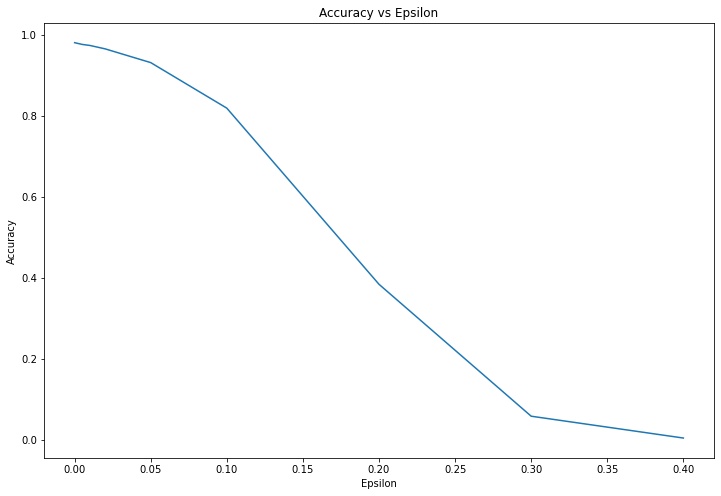

In [82]:
plt.figure(figsize=(12,8))
plt.plot(epsilons, accuracies)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [83]:
def plot_adv_samples(all_eps, examples):
    cnt = 0
    plt.figure(figsize=(10,10))

    for i in range(len(all_eps)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(all_eps),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])

            if j == 0:
                plt.ylabel(f"Eps: {all_eps[i]}", fontsize=10)

            orig, adv, ex = examples[i][j]
            plt.title(f"old label: {orig}\n new label: {adv}", fontsize=14)
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

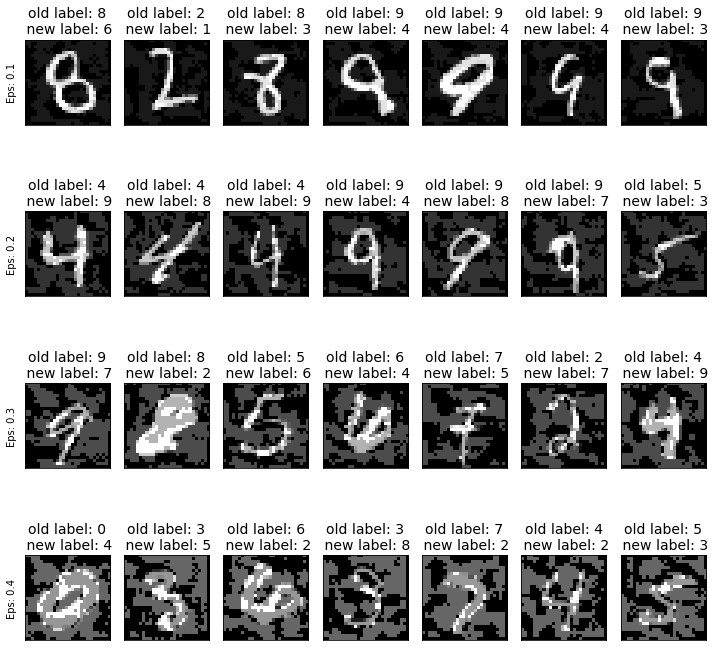

In [84]:
plot_adv_samples(epsilons[5:], results[5:])

В результате работы, мы реализовали один из простейших видов состязательных атак I-FGSM, который является модификацией атаки FGSM. В данном типе атаки мы воспринимаем сеть как "белый ящик", сама атака является нецелевой, то есть мы не могли задавать целевую "вредную" метку для входных данных. Минусом данной атаки является то, что примеры получаются слишком зашумленными.